음성에서의 특징 추출

In [8]:

import os
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import soundfile as sf
import librosa
import librosa.display

# 푸리에 변환을 위한 라이브러리
import math
from scipy.interpolate import splrep, splev

푸리에 변환

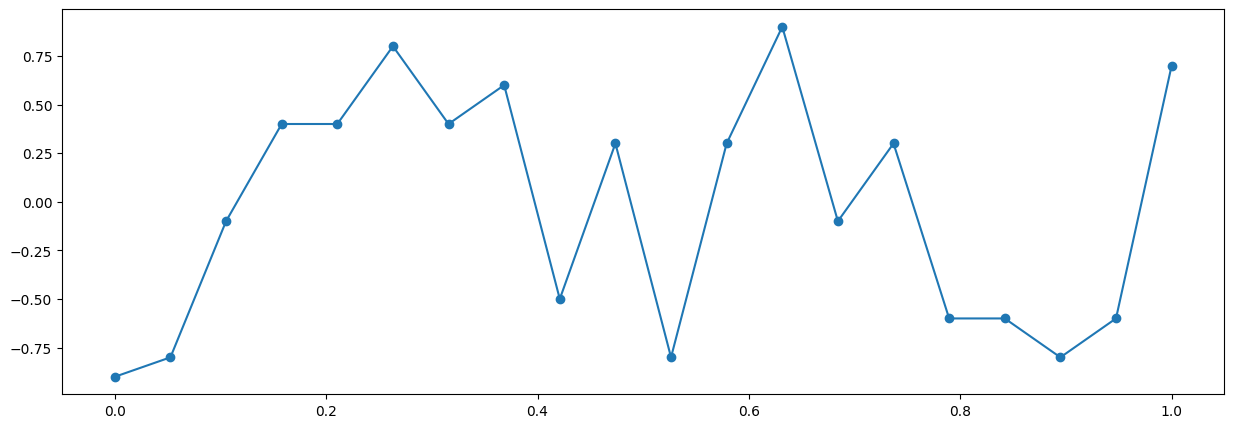

In [6]:
n = 20
x = np.linspace(0,1,n)
y= np.array([i/ 10 for i in np.random.randint(-10,10,n)])

plt.figure(figsize=(15,5))
plt.plot(x,y, marker='o')
plt.show()

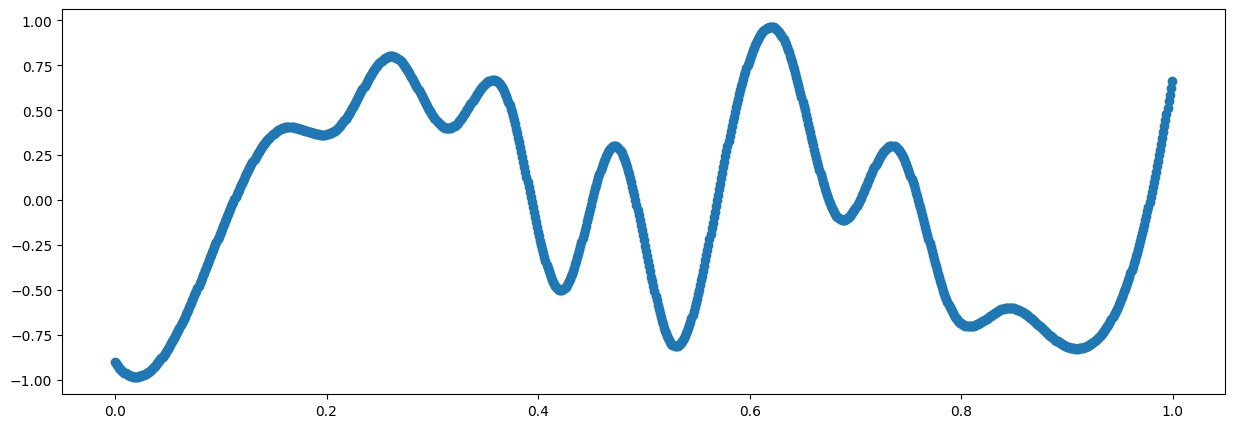

In [10]:
#필요한 샘플링 주기 (dt)는 최대 주파수 설정에 따라 변함
# FFT(고속 푸리에 변환) 의해 측정 가능한 최대 주파수를 500Hz로 성분 분석 하려면
#평균 샘플링 주기(fs)를 1000Hz로 설정
#샘플링 주기(dt)는 1/1000sec로 설정
#일정 시간 간격(1ms)마다의 신호값을 스플라인 곡선 추정으로 대처하여 그래프 표시

fs =1000
dt = 1/fs

spl = splrep(x,y) #스플라인 곡선으로 표한하기 위한 함수 

#샘플링 주기 0 ~ 100
x1= np.arange(0,1,dt)
y1 = splev(x1,spl)

plt.figure(figsize=(15,5))
plt.plot(x1,y1,marker='o')
plt.show()

In [11]:
#고속 푸리에 변환(FFT)를 이용하여 스펙트럼 그래프 표현

#주파수 생성
nfft = len(x1) #샘플 개수
df = fs/nfft
k = np.arange(nfft)
f = k*df # 0 ~ 최대 주파수 까지의 범위

#스펙트럼은 중앙을 기준으로 대칭이므로 절반만 구함
nfft_half = math.trunc(nfft/2)
f0 = f[ range(nfft_half)]

# 증폭값을 두 배로 계산
fft_y = np.fft.fft(y1)/ nfft*2
fft_y0 =fft_y[range(nfft_half)]

# 벡터(복소수)의 norm 측정(신호강도)
amp = abs(fft_y0)

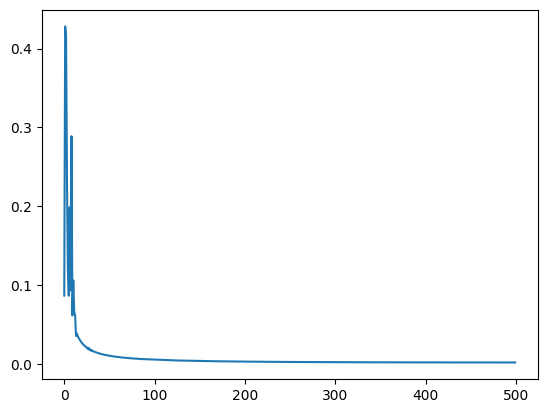

In [12]:
if True:
    plt.figure()
    plt.plot(f0,amp)
    plt.show()

In [14]:
# 상위 10개의 주파수 값
idxy = np.argsort(-amp)
for i in range(10):
    print(f'freq = {f0[idxy[i]]}, amp = {fft_y[idxy[i]]}')

freq = 1.0, amp = (-0.32354103677301715-0.2803640820132515j)
freq = 2.0, amp = (-0.35659791512936456-0.21258750745703558j)
freq = 8.0, amp = (0.20475917432090643+0.20367403641702947j)
freq = 3.0, amp = (0.18852606426090324+0.14064338582093974j)
freq = 6.0, amp = (0.022226700278713808+0.1975542005445045j)
freq = 4.0, amp = (-0.06659754853872073+0.0996518872758896j)
freq = 10.0, amp = (-0.03395681024676172+0.10009393481247639j)
freq = 7.0, amp = (0.008794117440975342-0.09253991027678429j)
freq = 0.0, amp = (-0.08651505910165107+0j)
freq = 5.0, amp = (0.07479213583200384+0.04307264106686245j)


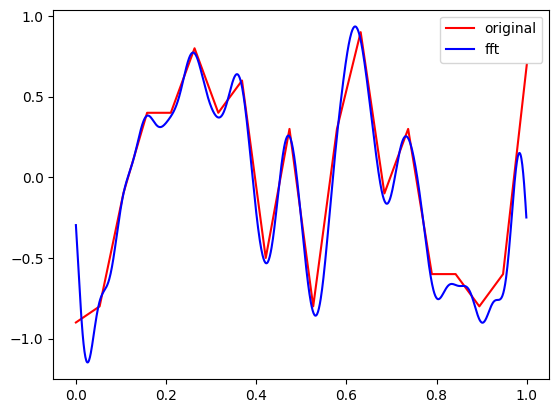

In [21]:
# 상위 20개 주파수로 복원해서 원본과 비교
newy = np.zeros( ( nfft, ) )
arfreq = []
arcoec = []
arcoes = []

for i in range( 20 ):
    freq = f0[idxy[i]]
    yx = fft_y[idxy[i]]
    coec = yx.real
    coes = yx.imag * -1
    newy += coec * np.cos( 2 * np.pi * freq * x1 ) + coes * np.sin( 2 * np.pi * freq * x1 )
    arfreq.append( freq )
    arcoec.append( coec )
    arcoes.append( coes )
    
plt.figure()
plt.plot( x, y, c = 'r', label='original' )
plt.plot( x1, newy, c = 'b', label='fft' )
plt.legend()
plt.show()

In [ ]:
#상위 주파수를 하나씩 더해가면서 변하는 모습

plt.figure(figsize=(20,15))
plti = 0
ncnt =11
newy = np.zeros((nfft,))

for i in range(ncnt +1):
    freq = f0[idxy[i]]
    yx = fft_y[idxy[i]]
    coec = yx.real
    coes =yx.imag*-1
    newy += coec*np.cos(2*np.pi*freq*x1)+coes*np.sin(2*np.pi*freq*x1)
    
    plti += 1
    plt.subplot(4,4,plti)
    plt.title("N={}".format(i+1))
    plt.plot(x1, newy, label = 'fft')
    plt.plot

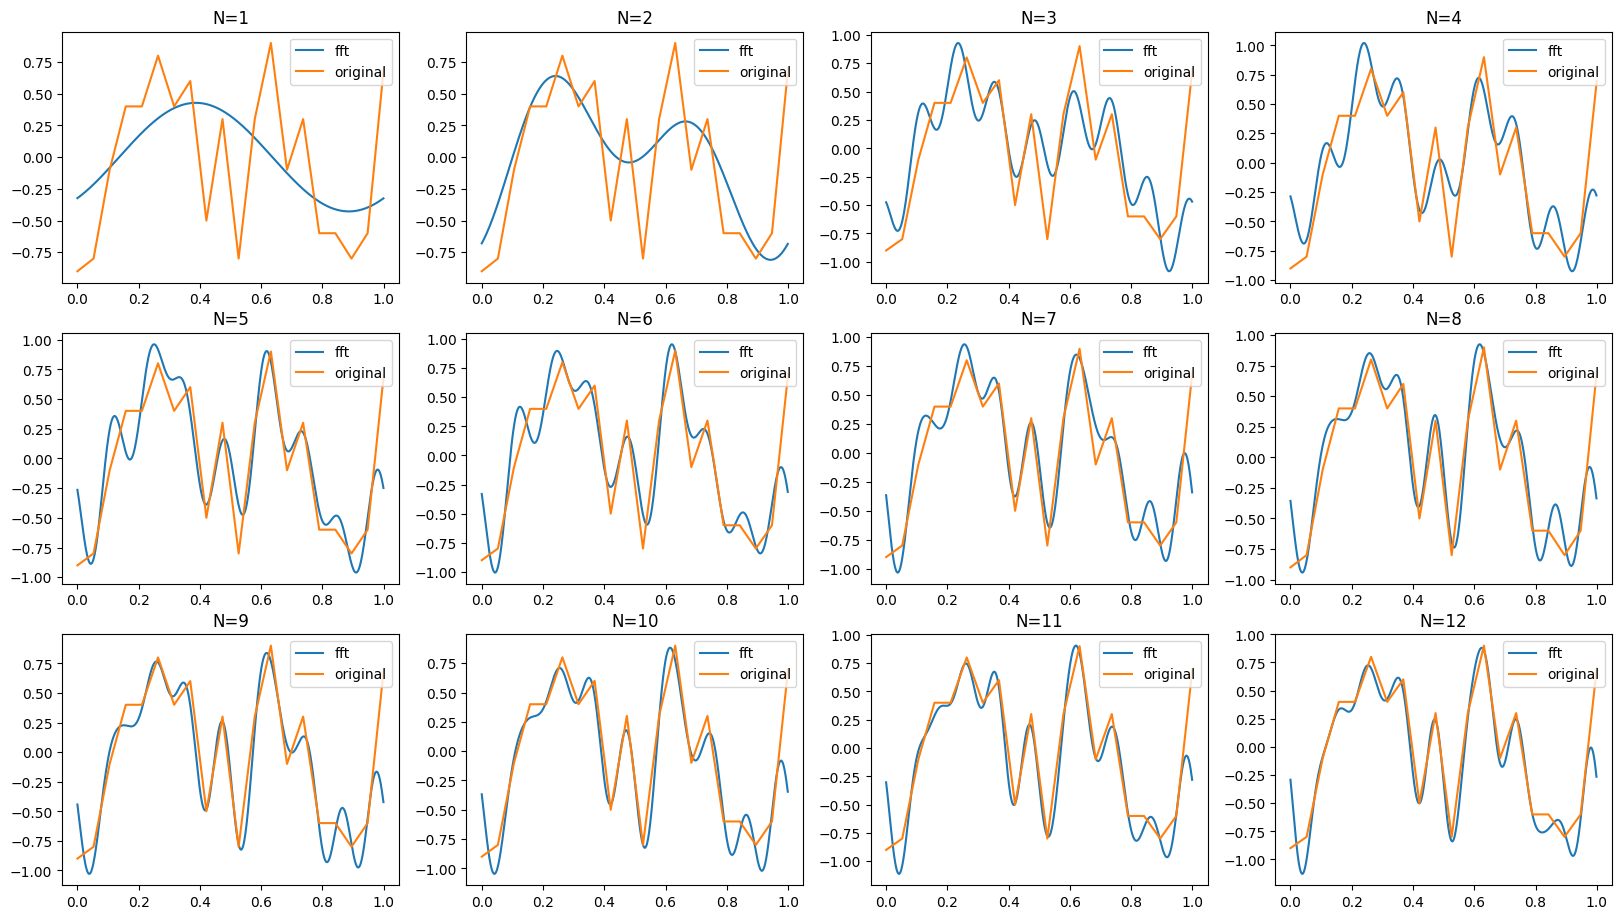

In [22]:
# 상위 주파수를 하나씩 더해가면서 변하는 모습
plt.figure( figsize = ( 20, 15 ) )
plti = 0
ncnt = 11
newy = np.zeros((nfft, ))

for i in range( ncnt + 1 ):
    freq = f0[idxy[i]]
    yx = fft_y[idxy[i]]
    coec = yx.real
    coes = yx.imag * -1
    newy += coec * np.cos( 2 * np.pi * freq * x1 ) + coes * np.sin( 2 * np.pi * freq * x1 )
    
    plti += 1
    plt.subplot( 4, 4, plti )
    plt.title( "N={}".format( i + 1 ) )
    plt.plot( x1, newy, label = 'fft' )
    plt.plot( x, y, label = 'original' )
    plt.legend()

MFCC feature 생성과정

wave file 읽기

In [15]:
import scipy.io.wavfile
sample_rate, signal = scipy.io.wavfile.read('C:\workspace\data\example.wav')

print(f'sample rate: {sample_rate}')
print(f'signal :\n{signal}\n')
print(f'signal length : {len(signal)}')
print(f'signal time : {len(signal)/sample_rate}')

sample rate: 16000
signal :
[36 37 60 ...  7  9  8]

signal length : 183280
signal time : 11.455


In [16]:
#음성의 초반 3.5초 구간만 잘라서 MFCC 작성
signal = signal[0:int(3.5*sample_rate)]

print(f'signal length : {len(signal)}')

signal length : 56000


Preemphasis

In [19]:
# Yt = Xt -aXt-1
#a(alpha) : 0.95 또는 0.97 사용
pre_emphasis= 0.97
emphasized_signal =np.append(signal[0], signal[1:]-pre_emphasis*signal[:-1])

In [18]:
print(f'emphasized_signal : {emphasized_signal}')

emphasized_signal : [  36.      2.08    1.11 ... -746.76 -496.5  -225.87]


Framing

In [23]:
frame_size = 0.025 # frame size
frame_stride = 0.01 # frame간 겹치는 구간

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate

signal_length = len( emphasized_signal )
frame_length = int( round( frame_length ) )
frame_step = int( round( frame_step ) )
num_frames = int( np.ceil( float( np.abs( signal_length - frame_length ) ) / frame_step ) )

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros( ( pad_signal_length - signal_length ) )
pad_signal = np.append( emphasized_signal, z )

indices = np.tile( np.arange( 0, frame_length ), ( num_frames, 1 ) ) + \
          np.tile( np.arange( 0, num_frames * frame_step, frame_step ), ( frame_length, 1 ) ).T

frames = pad_signal[ indices.astype( np.int32, copy = False ) ] # 최종 frame 


In [24]:
print( f'pad_signal = {pad_signal}' )
print( f'pad_signal length = {len(pad_signal)}\n' )

print( f'indices = {indices} {indices.dtype}\n' )
print( f'indices.shape = {indices.shape}' )

print( f'frames = {frames} {frames.dtype}\n' )
print( f'frames.shape = {frames.shape}' )

pad_signal = [36.    2.08 24.11 ...  0.    0.    0.  ]
pad_signal length = 56080

indices = [[    0     1     2 ...   397   398   399]
 [  160   161   162 ...   557   558   559]
 [  320   321   322 ...   717   718   719]
 ...
 [55200 55201 55202 ... 55597 55598 55599]
 [55360 55361 55362 ... 55757 55758 55759]
 [55520 55521 55522 ... 55917 55918 55919]] int32

indices.shape = (348, 400)
frames = [[  36.      2.08   24.11 ...    4.56    3.74    2.89]
 [  16.43  -32.15  -47.2  ...  -13.06  -16.45    2.07]
 [  -9.     -9.27   11.46 ...   -5.09   -7.24   -2.45]
 ...
 [ 315.7   130.65  211.81 ... -121.15  -17.69 -195.02]
 [ 283.62 1098.42  815.34 ...   20.53  136.92  150.79]
 [ -59.03 -212.81 -289.18 ... -157.35  -81.12   24.54]] float64

frames.shape = (348, 400)


## Windowing

In [25]:
frames *= np.array([0.54-0.46*np.cos((2*np.pi*n)/(frame_length - 1)) for n in range(frame_length)])

In [26]:
print( f'frames = {frames} {frames.dtype}\n' )
print( f'frames.shape = {frames.shape}' )

frames = [[  2.88         0.16651863   1.9343     ...   0.36584023   0.29941331
    0.2312    ]
 [  1.3144      -2.57383364  -3.78676733 ...  -1.04777926  -1.31693821
    0.1656    ]
 [ -0.72        -0.7421287    0.91941427 ...  -0.40836114  -0.57961293
   -0.196     ]
 ...
 [ 25.256       10.45945147  16.99311838 ...  -9.7196369   -1.41620893
  -15.6016    ]
 [ 22.6896      87.93624714  65.41319644 ...   1.64708333  10.96140908
   12.0632    ]
 [ -4.7224     -17.03693738 -23.20036812 ... -12.62389489  -6.49422659
    1.9632    ]] float64

frames.shape = (348, 400)


## 푸리에 변환

In [27]:
NFFT = 512
dft_frames = np.fft.rfft( frames, NFFT )

In [28]:
dft_frames

array([[  18.58681572  +0.j        ,  -14.01988178 -84.91698726j,
         -24.70392533+106.88963159j, ...,  -26.66158624  -5.85474324j,
           0.92680879 +28.72849855j,   32.82338322  +0.j        ],
       [-142.51526149  +0.j        ,   85.6674828 +108.25845827j,
          13.38303476-108.51765447j, ...,  -10.58513364  +4.31215777j,
           7.05534013  -2.14342983j,   -3.03115655  +0.j        ],
       [ -19.2843489   +0.j        ,  -15.14198098 -16.21735682j,
         -40.12895986 +59.02120051j, ...,   -4.25775098 -14.59761671j,
         -10.25228518  +7.21787503j,    8.21971695  +0.j        ],
       ...,
       [ -20.99872977  +0.j        , -173.80587746 -75.85843408j,
        -120.10047358+121.33988075j, ...,  -36.66157943-135.12987296j,
        -150.42479757 -89.13659856j,  214.56477173  +0.j        ],
       [ 223.33492956  +0.j        ,  268.55310205 +78.36772313j,
         177.86153856 +13.40968462j, ..., -471.85194623-511.29061637j,
          45.11248225+373.13984952j

In [29]:
mag_frames = np.absolute( dft_frames )

In [30]:
mag_frames

array([[ 18.58681572,  86.06655454, 109.70723435, ...,  27.29685328,
         28.74344453,  32.82338322],
       [142.51526149, 138.05365405, 109.33977754, ...,  11.4297751 ,
          7.37374503,   3.03115655],
       [ 19.2843489 ,  22.18743451,  71.37111131, ...,  15.20588232,
         12.53822441,   8.21971695],
       ...,
       [ 20.99872977, 189.6390916 , 170.72636122, ..., 140.01483483,
        174.85123085, 214.56477173],
       [223.33492956, 279.75394305, 178.36632681, ..., 695.74589726,
        375.85699854, 166.92458692],
       [ 70.92601653, 148.55743749,  51.98745437, ..., 385.55333259,
        183.12959323,  11.68459131]])

## Spectrum

In [31]:
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2)) # power spectrum 생성 수식

In [32]:
pow_frames

array([[6.74745544e-01, 1.44676793e+01, 2.35071822e+01, ...,
        1.45530898e+00, 1.61364376e+00, 2.10424704e+00],
       [3.96691402e+01, 3.72242410e+01, 2.33499745e+01, ...,
        2.55155779e-01, 1.06195539e-01, 1.79451368e-02],
       [7.26340063e-01, 9.61488770e-01, 9.94889752e+00, ...,
        4.51599330e-01, 3.07045061e-01, 1.31960443e-01],
       ...,
       [8.61223929e-01, 7.02402052e+01, 5.69286922e+01, ...,
        3.82893632e+01, 5.97127987e+01, 8.99180494e+01],
       [9.74189273e+01, 1.52855993e+02, 6.21377862e+01, ...,
        9.45434284e+02, 2.75915007e+02, 5.44215190e+01],
       [9.82519496e+00, 4.31041255e+01, 5.27870198e+00, ...,
        2.90334711e+02, 6.55008748e+01, 2.66659520e-01]])

## Mel Filter Bank

In [33]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10( 1 + ( sample_rate / 2 ) / 700 ) ) # Convert Hz to Mel

mel_points = np.linspace( low_freq_mel, high_freq_mel, nfilt + 2 )
hz_points = ( 700 * ( 10 ** ( mel_points / 2595 ) - 1 ) ) # Convert Mel to Hz
bins = np.floor( ( NFFT + 1 ) * hz_points / sample_rate )

fbank = np.zeros( ( nfilt, int( np.floor( NFFT / 2 + 1 ))))

for m in range( 1, nfilt + 1 ):
    f_m_minus = int( bins[ m - 1 ] )
    f_m = int( bins[ m ] )
    f_m_plus = int( bins[ m + 1 ] )
    for k in range( f_m_minus, f_m ):
        fbank[ m - 1, k ] = ( k - bins[ m - 1 ] ) / ( bins[ m ] - bins[ m - 1 ] )
    for k in range( f_m, f_m_plus ):
        fbank[ m - 1, k ] = ( bins[ m - 1 ] - k ) / ( bins[ m - 1 ] - bins[ m ] )    

In [34]:
len(fbank[0]) #filtter 길이

257

In [36]:
len(fbank[39])

257

In [37]:
fbank[0] #저주파 영역을 세밀하게 관찰

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [38]:
fbank[39] # 고주파 영역을 세밀하게 관찰

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [39]:
filter_banks =np.dot(pow_frames, fbank.T)
filter_banks =np.where(filter_banks ==0, np.finfo(float).eps, filter_banks)

In [40]:
filter_banks

array([[1.44676793e+01, 3.50544194e+01, 4.24615508e+00, ...,
        1.90533510e+02, 3.75336827e+02, 3.22503211e+02],
       [3.72242410e+01, 2.63613939e+01, 2.93141203e+00, ...,
        7.63512902e+01, 8.47973278e+01, 8.51072703e+01],
       [9.61488770e-01, 3.18233265e+01, 4.06464584e+01, ...,
        1.27093017e+02, 1.78318528e+02, 1.12130674e+02],
       ...,
       [7.02402052e+01, 1.29082219e+02, 2.87959962e+04, ...,
        1.96115989e+04, 7.41470825e+03, 1.00556609e+04],
       [1.52855993e+02, 1.22847568e+02, 3.08066660e+04, ...,
        1.34388303e+04, 1.69753852e+04, 3.50885243e+04],
       [4.31041255e+01, 4.85811615e+01, 2.99542714e+04, ...,
        2.34558049e+04, 1.12401903e+04, 1.36805077e+04]])

## Log Mel Spectrum

In [41]:
filter_banks = 20*np.log10(filter_banks)

In [42]:
filter_banks

array([[23.20797748, 30.89485556, 12.55991703, ..., 45.59942735,
        51.48842357, 50.17068086],
       [31.41651703, 28.4193674 ,  9.34153733, ..., 37.6563276 ,
        38.56764333, 38.59933322],
       [-0.34111568, 30.05491148, 32.18045421, ..., 42.08243379,
        45.02392939, 40.99448865],
       ...,
       [36.93171543, 42.21732842, 89.18664214, ..., 85.85026003,
        77.40188135, 80.04821235],
       [43.68564944, 41.78733125, 89.772894  , ..., 82.5672294 ,
        84.59639274, 90.90330208],
       [32.69037676, 33.72935787, 89.52917521, ..., 87.40500681,
        81.01547329, 82.72204432]])

In [43]:
filter_banks.shape

(348, 40)

## MFCC

In [44]:
from scipy.fftpack import dct

In [45]:
#Mel Spectrum 이나 Log Mel Spectrum 은 feature간의 상관관계가 존재한다.
#feature간 상관관계가 존재하면 GMM 음향모델에서는 제대로 사용할 수 없다.
#따라서 Log Mel Spectrum에 역푸리에 변환을 적용하여 feature간 상관관계를 제거하게 된다.


num_ceps =12
mfcc =dct(filter_banks,type=2, axis=1,norm='ortho')[:,1:(num_ceps+1)] # 

In [46]:
mfcc.shape
# 최종 MFCC로 만들어지면서 348,40의 모양이 348,12로 줄어드는 현상이 생기기 때문에 Mel Spectrum 이나 Log Mel Spectrum을 사용하기도 한다는 것.

(348, 12)

In [47]:
mfcc

array([[-7.55402100e+01, -7.57326474e+01,  2.88347099e+00, ...,
        -2.76008992e-01,  9.93370968e-03, -8.24718407e-01],
       [-5.88168284e+01, -7.21810521e+01,  6.13241451e+00, ...,
         3.38861953e+00, -2.92179142e+00,  1.34018671e+01],
       [-5.26385859e+01, -6.48474576e+01, -4.08503079e+00, ...,
        -2.11762963e+00, -1.58148326e+00, -8.24290257e+00],
       ...,
       [-1.44086433e+01, -4.41741991e+01, -3.31664513e+00, ...,
        -1.31673001e+01, -8.96950578e+00, -2.31713079e+01],
       [-1.82615500e+01, -3.85356305e+01, -4.28817530e+00, ...,
        -7.62968052e+00, -1.14681107e+01, -1.87532279e+01],
       [-1.63595675e+01, -4.82536111e+01, -6.41261471e+00, ...,
        -1.65686310e+01, -1.09896409e+01, -2.40024761e+01]])

## 특성 추출 (음성데이터 전처리)
## librosa 사용

In [3]:

import os
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import soundfile as sf
import librosa
import librosa.display
sample_path = 'C:\workspace\data\sample.wav'
example_path = 'C:\workspace\data\example.wav'
wait_path = 'C:\workspace\data\wait.wav'
input_path = 'C:\workspace\data\input.wav'

## 음성 load

In [5]:
data, rate = librosa.load(wait_path, mono=True, sr=44100)
#sample = librosa.load('C:\workspace\data\sample.wav', mono=True, sr=44100)
print(f'sample rate :{rate}')
print(f'data : [type : {type(data)}, shape : {data.shape} \
    len : {len(data)}\ ndata: {data}')

duration = librosa.get_duration(y =data, sr=rate)
print(f'\nduration : {duration}')

sample rate :44100
data : [type : <class 'numpy.ndarray'>, shape : (66156,)     len : 66156\ ndata: [-2.0064239e-05  9.1962831e-04  2.1942775e-05 ... -9.3633935e-07
  1.9246072e-06  1.0805161e-06]

duration : 1.5001360544217688


In [1]:
# 웨이브폼 시각화
plt.figure(figsize=(10, 4))
librosa.display.waveshow(data, sr=rate)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()



SyntaxError: invalid syntax (2661044417.py, line 9)

## Spectrum 생성

In [7]:
#STFT(Short Time Fourier Transform) 이 함수를 통하여 framing, windowing, 푸리에 변환 까지 해주는 기능이다. 즉 Spectrum까지 만들어 주는 기능 
stft_result = librosa.stft(data, n_fft=4096, win_length= 4096, hop_length=515)
#stft_result 푸리에 변환이 적용된 스펙트럼
D=np.abs(stft_result)
S_dB= librosa.power_to_db(D,ref=np.max)

print(f'stft : {stft_result}')

stft : [[ 6.70918286e-01+0.00000000e+00j  7.17261910e-01+0.00000000e+00j
   6.52154982e-01+0.00000000e+00j ... -1.96503460e+00+0.00000000e+00j
  -1.33439910e+00+0.00000000e+00j -8.75884712e-01+0.00000000e+00j]
 [-5.46914637e-01+4.31083292e-01j -7.87267506e-01-1.29961506e-01j
  -2.56904751e-01-4.87155527e-01j ...  5.96572995e-01+9.29793000e-01j
   3.14905107e-01+2.35936031e-01j  6.06987834e-01+1.22146554e-01j]
 [ 2.42949992e-01-6.95029974e-01j  7.15514958e-01+2.24770069e-01j
  -1.03016816e-01+7.16681600e-01j ...  9.59703624e-01-7.08924532e-01j
   3.88655603e-01+7.18051016e-01j -5.67284822e-01+9.59018469e-02j]
 ...
 [-2.99416803e-04+1.79942177e-07j -2.47080925e-06-2.55020219e-04j
   1.48246560e-04-2.75513457e-06j ... -1.47103108e-07-2.56821551e-07j
   2.99424300e-07-2.29526279e-07j  3.09643667e-07+2.88322497e-07j]
 [ 2.99477222e-04-7.17735986e-08j -1.79522816e-04+1.81244162e-04j
  -1.38167104e-06-1.48303065e-04j ... -9.16803842e-08+8.37559995e-08j
   1.23805123e-07+1.31962480e-07j -3.552

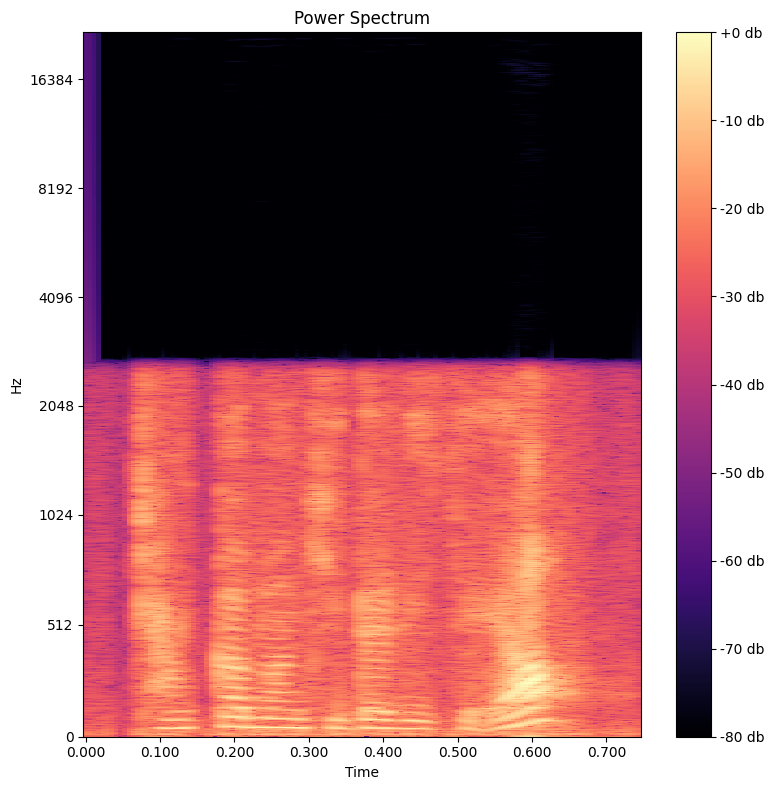

In [8]:
plt.figure(figsize=(8,8))
librosa.display.specshow(S_dB, sr=rate, hop_length=256, y_axis='mel',x_axis='time')
plt.title('Power Spectrum')
plt.colorbar(format='%+2.0f db')
plt.tight_layout()
plt.show()

각각의 frame(짧은 시간으로 자른 신호)이 각 주파수성분을 얼마만큼 가지고 있는 지 표현하게 된다. 위의 예에서는 7초라는 시간동안 거의 대부분을 저주파를 강하게 가지고 있다고 볼 수 있는 것이다. 

## Mel Spectrum 생성

In [9]:
#Mel Spectrum
n_fft= 2048
win_length =2048
hop_length = 1024
n_mels = 128


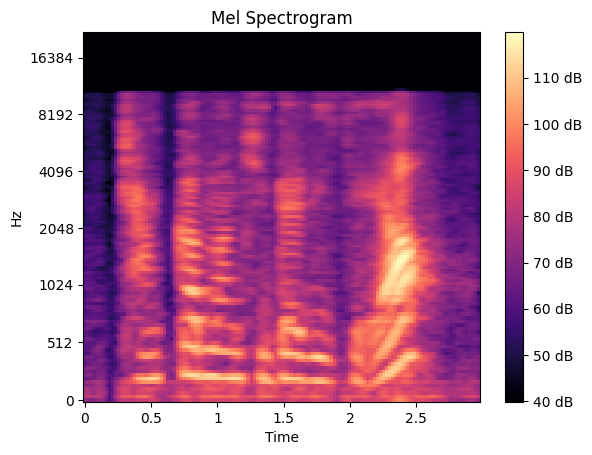

In [11]:
mel_spec = librosa.feature.melspectrogram(S =D, sr=rate, n_mels=n_mels,hop_length=hop_length, win_length=win_length)
librosa.display.specshow(librosa.amplitude_to_db(mel_spec,ref=0.00002),
                         sr =rate, hop_length=hop_length, y_axis='mel',x_axis='time')

plt.title('Mel Spectrogram')
plt.colorbar(format='%2.0f dB')
plt.show()

진폭까지 반영되고 저주파의 영역을 조금 더 강조 한 것이다.

## MFCC 생성

In [12]:
mfcc = librosa.feature.mfcc(y=data,sr=rate, n_mfcc=50)


In [13]:
mfcc.shape

(50, 130)

In [14]:
mfcc

array([[-3.87035980e+02, -3.69506866e+02, -3.72954742e+02, ...,
        -3.28503479e+02, -3.44723846e+02, -3.81023987e+02],
       [ 9.09787369e+01,  9.57823257e+01,  8.69379578e+01, ...,
         1.02863266e+02,  9.60415497e+01,  8.26264343e+01],
       [ 5.90965796e+00, -7.68745542e-02, -2.70674419e+00, ...,
        -1.86788731e+01, -1.51642256e+01, -2.25407338e+00],
       ...,
       [ 1.60788012e+00,  4.04585171e+00,  3.08749080e+00, ...,
         3.70288515e+00,  5.91953945e+00,  4.33162123e-01],
       [-3.31991839e+00,  2.78260589e-01, -3.54313552e-01, ...,
        -5.80416620e-01,  2.78799295e+00,  3.04526901e+00],
       [-2.61492419e+00, -1.90013993e+00,  1.67323470e-01, ...,
         1.32957125e+00,  1.27413660e-01, -9.90276814e-01]], dtype=float32)

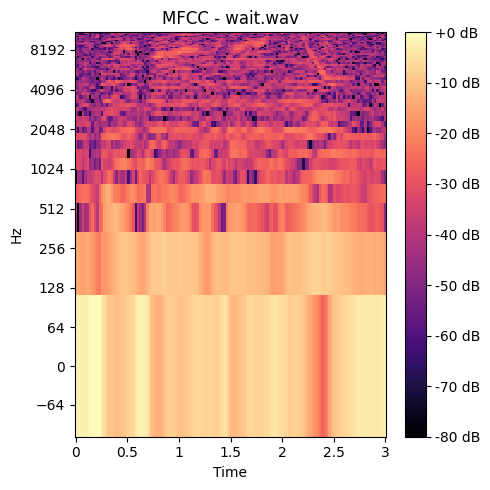

In [15]:
plt.figure(figsize=(5,5))
librosa.display.specshow(librosa.amplitude_to_db(mfcc, ref=np.max),
                         y_axis='log',x_axis='time')
plt.title('MFCC - wait.wav')
plt.colorbar(format= '%+2.0f dB')
plt.tight_layout()
plt.show()